# Week 3 - 5 # 

Task: We needed to build a function that takes four required parameters (which is the dataset, the model, the desired class, and the undesired coordinates)

Steps: 
1. We first read in the dataset and construct our model using sklearn library (svm classifier, logistic regression classifier, multi-layer perceptron)
2. We then fit the model according to the dataset provided. 
3. We generate a meshgrid of points from which we applied the model to. 
4. We retrieved the predictions of the model for those values. 
5. We determined the decision boundary based on the model's predictions for the meshgrid of points. 
6. We interpolate the decision boundary with the points found in step 5. 
7. We apply distance algorithm / orthogonality algorithm to the interpolated points to find the point of minimal distance. 
8. We show that the point crosses the decision boundary in a plot.

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


As shown in the report for weeks 1 - 3, the displacement algorithm uses orthogonality to find the point where the interpolated point vector is orthogonal to the vector from the point to the actual data point. 

We also have shown that we can replace this algorithm with a simple distance algorithm to get the same result. The distance algorithm just uses the distance formula $D = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$ and determines which of the interpolated points is closest to the actual data point.

In [16]:
import math 

# Determines the new point that takes the original data point across the decision boundary.
def direction_func(data_pt, final_dist_vec, scaler, direction, x1=0): 
    if direction == "negative": 
        x1 = x1 * -1
    margin = np.array([x1, x1]) 
    modified_pt = data_pt - final_dist_vec*scaler + margin
    return modified_pt

# Distance formula function
def J(x1, y1, x2, y2): 
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

# Finds the interpolated point with a minimal distance from the data point
def displacement_func2(X_pred, Y_pred, datapt, margin=0): 
    X_pred = X_pred.flatten() 
    Y_pred = Y_pred.flatten()

    min_point_vector = (-1, -1)
    min_dist = float('inf')


    for k in range(len(X_pred)): 
        x, y = X_pred[k], Y_pred[k]

        dist = J(x,y, datapt[0], datapt[1])

        if min_dist > dist: 
            min_dist = dist 
            min_point_vector = (datapt[0] - x, datapt[1] - y)

    return min_point_vector

# Uniqueness of orthogonal projection: https://math.stackexchange.com/questions/953997/uniqueness-of-orthogonal-projections 
# Minimum distance orthogonal projection: https://math.stackexchange.com/questions/2304079/show-orthogonal-projection-is-minimal-distance 
def displacement_func(func, X_pred, Y_pred, data_pt, margin=0): 
    X_pred = X_pred.flatten() 
    Y_pred = Y_pred.flatten()

    min_point_vector = (-1, -1)
    min_orthogonal = 1

    for k in range(1, len(X_pred)): 
        dist_x, dist_y = margin, Y_pred[k] - func(X_pred[k] - margin)
        point_dist_x, point_dist_y = data_pt[0] - X_pred[k], data_pt[1] - Y_pred[k]

        line_vector = np.array([dist_x, dist_y]).T 
        point_vector = np.array([point_dist_x, point_dist_y]) 

        # Taking the magnitudes of both vectors
        line_vector_m = np.linalg.norm(line_vector)
        point_vector_m = np.linalg.norm(point_vector)
        
        line_vector_norm = line_vector / line_vector_m
        point_vector_norm = point_vector / point_vector_m

        # Should be in the range of [-1, 1]
        orthogonal = np.matmul(line_vector_norm, point_vector_norm)

        # Taking the absolute value since we only that value of orthogonality is as close to 0 as possible
        orthogonal = abs(orthogonal)
                
        if min_orthogonal > orthogonal: 
            min_orthogonal = orthogonal
            min_point_vector = point_vector

    return min_point_vector

# Finding the Optimal Point (orthogonal point to the decision boundary) # 

To find the optimal point, we create a function optimal_point that takes in the four required parameters (df, model, desired_class, undesired_coords) to represent the parameters of the function needed to complete the task which is a function that can return the optimal point independent of the model, dataset, and data point values. 

Because we cannot easily determine the decision boundary if the function is to be model agnostic, we need to build a function that generates the decision boundary in the case of binary classification. We create a function boundary_generator in order to achieve this. The function iterates over each meshgrid point row by row and finds the point at which the classification changes from -1 to 1 or 1 to -1. This pattern is used to find the points of the decision boundary. 

Other parameters are added to the optimal point function: 
- step_size: the size of the step between meshgrid points (to generate the boundary)
- N: the total number of interpolated points
- margin: the added margin needed to get the optimal point across the boundary (not just on the boundary)
- test: Whether to use the orthogonality algorithm (displacement_func -- in the case of False) or the distance algorithm (displacement_func2 -- in the case of True) 
- contours_val: Uses decision_function for svm to see if the decision boundary for svm matches the boundary generated by boundary_generator

In [14]:
from scipy.interpolate import interp1d

# Generates the decision boundary in the case of binary classification
def boundary_generator(xx1, xx2, model, margin=0.005): 
    data = np.array([xx1.ravel(), xx2.ravel()]).T
    class_labels = model.predict(data).reshape(xx1.shape)
    boundary_df = pd.DataFrame([], columns=['x1', 'x2']) 

    for i in range(0, class_labels.shape[0]): 
        for j in range(1, class_labels.shape[1]): 
            if class_labels[i, j] != class_labels[i, j-1]: 
                result = smooth_op(model, np.array([xx1[i, j-1], xx2[i, j-1]]).reshape((1, data.shape[1])),   np.array([xx1[i,j], xx2[i,j]]).reshape((1, data.shape[1])))
                result = np.squeeze(result, axis=0)
                boundary_df.loc[len(boundary_df)] = result

    return boundary_df

# Helps to locate a better decision boundary
def smooth_op(model, left, right):
    model_left = model.predict(left) 
    model_right = model.predict(right) 

    while model_left != model_right:  
        left = (left + right) / 2 
        model_left = model.predict(left) 
    
    return left 

# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(df, model, desired_class, undesired_coords, step_size=0.005, N=10000, margin=0.0001, test=False, contours_val=False): 

    # First feature
    X1=df['x1']

    # Second feature
    X2=df['x2']

    # Creating feature matrix from a set of two features
    X_train=np.array(list(zip(X1,X2)))

    # Getting labels of the features in the feature matrix
    y_train=df['y'].values

    model.fit(X_train, y_train)

    X = X_train
    x1_min, x1_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    x2_min, x2_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step=step_size),np.arange(x2_min, x2_max, step=step_size))

    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

    # Cubic interpolation 
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
    Y_pred = f(X_pred)

    if contours_val: 
        Z = model.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        contours = plt.contour(xx1, xx2, Z, levels=[-1, 0, 1])

        x_coords, y_coords = None, None
        i = 0 
        for collection in contours.collections:
            for path in collection.get_paths():
                if i == 1: 
                    vertices = path.vertices
                    x_coords = vertices[:, 0]
                    y_coords = vertices[:, 1]
                i+=1
        plt.plot(x_coords, y_coords, label='Decision Boundary')

    plt.plot(X_pred, Y_pred)  # Interpolated curve
    plt.xlabel('x')
    plt.ylabel('y')

    # Add a legend for the line plot
    plt.legend()

    if not test: 
        # Returns the minimum distance vector between the undesired coordinates and the decision boundary
        min_dist_vector = displacement_func(f, X_pred, Y_pred, undesired_coords, margin=margin)
    else: 
        min_dist_vector = displacement_func2(X_pred, Y_pred, undesired_coords)

    if desired_class: 
        undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]]).reshape(1, -1)  
        optimal_datapt = direction_func(undesired_datapt, min_dist_vector, 1, 'negative', x1=margin)

        color_ls = []
        # Depending on labels assigns as 'b' or 'r' (blue or red) 
        for k in y_train:
            if k == 1:
                color_ls.append('b')
            else:
                color_ls.append('r')
        color_ls
        label = []
        for k in y_train:
            if k == 1:
                label.append('H')
            else:
                label.append('NH')
        label
        plt.scatter(undesired_datapt[0,0], undesired_datapt[0,1], c = 'r')
        plt.text(undesired_datapt[0,0]+0.002, undesired_datapt[0,1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0,0], optimal_datapt[0,1], c = 'b')
        plt.text(optimal_datapt[0,0]+0.002, optimal_datapt[0,1]+0.002, 'H')
        plt.plot([undesired_datapt[0,0], optimal_datapt[0,0]], [undesired_datapt[0,1],optimal_datapt[0,1]], linestyle='--')
        print(J(undesired_datapt[0,0],undesired_datapt[0,1], optimal_datapt[0,0], optimal_datapt[0,1]))
        # Display the plot
        return optimal_datapt 
    else: 
        reduction = 0.2 
        min_dist_vector = (1 - reduction) * min_dist_vector
        optimal_datapt = direction_func(undesired_coords, min_dist_vector, 1, 'negative', x1=margin)
        plt.scatter(undesired_datapt[0,0], undesired_datapt[0,1], c = 'r')
        plt.text(undesired_datapt[0,0]+0.002, undesired_datapt[0,1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0,0], optimal_datapt[0,1], c = 'b')
        plt.text(optimal_datapt[0,0]+0.002, optimal_datapt[0,1]+0.002, 'H')
        plt.plot([undesired_datapt[0,0], optimal_datapt[0,0]], [undesired_datapt[0,1],optimal_datapt[0,1]], linestyle='--')
        # Display the plot
        return optimal_datapt

5.3606453422103435


array([[ 3.76930119, 17.82683826]])

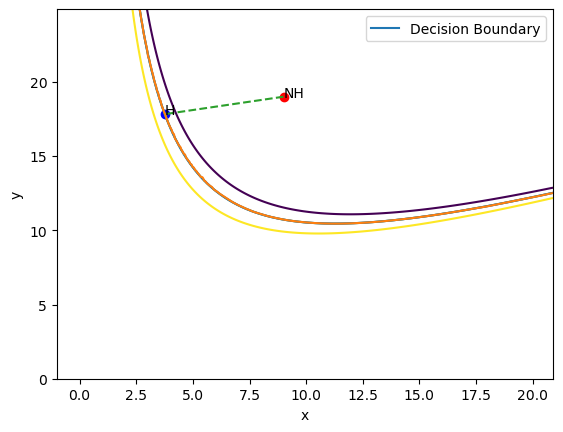

In [17]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(9,19), contours_val=True, N=100000, step_size=0.1, margin=0.00001, test=False)
optimal_projection

5.358821738602314


array([[ 3.78242708, 17.77774667]])

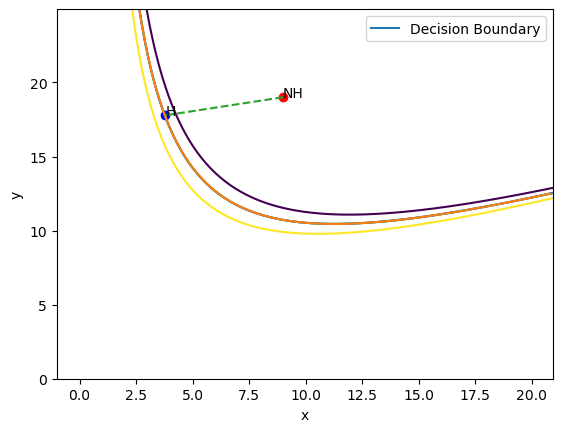

In [18]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(9,19), contours_val=True, N=100000, step_size=0.05, test=True)
optimal_projection

# Finding the Optimal Points # 

The code below finds the optimal data points with the orthogonality algorithm described earlier. In the code below, we iterate over each non-health data point and find the optimal points for each. We then plot those optimal data points as blue, 'healthy' data points in the graphic below.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.6346825786751746


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8082611109896327


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.368143842702653


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.823108401304631


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.5454259007457205


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.415402826135256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2823003745558275


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.048119386634009


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.965008159472882
4.747229092074945


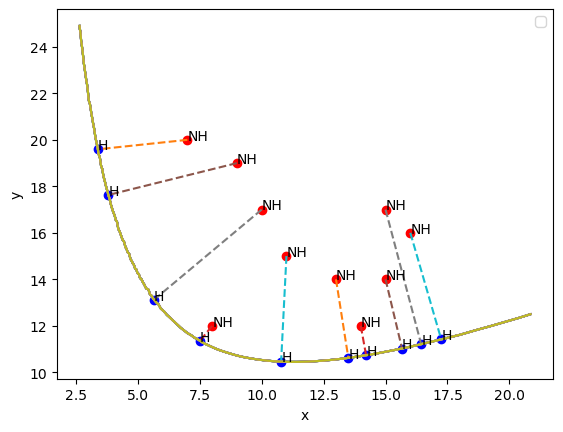

In [20]:
# Data frame consisting of all "non-healthy" data points or points where the classification is -1
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])

optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

# Iterates over each of the rows of the undesired dataframe and finds the optimal point
for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  

    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), contours_val=False, N=100000, step_size=0.1, margin=0.0001, test=False)
    
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

# Optimal Points # 

These are the optimal data points founds after iterating over each "non-healthy" data point. These are the points that are colored blue in the graphic above.

In [21]:
optimal_datapts

,x1,x2
0,3.388099,19.593686
1,7.511897,11.355763
2,3.809980,17.628630
3,5.654386,13.123890
4,10.785017,10.459661
5,13.497390,10.621009
6,14.214296,10.735733
7,15.664486,11.025191
8,16.437448,11.210780
9,17.246992,11.419477


In [28]:
dist_df_ortho_algo = pd.DataFrame(data=[], columns=["distance"])

for k in range(optimal_datapts.shape[0]): 
    dist_df_ortho_algo.loc[len(dist_df_ortho_algo)] = J(optimal_datapts.iloc[k,0], optimal_datapts.iloc[k,1], undesired_df.iloc[k,0], undesired_df.iloc[k,1])

dist_df_ortho_algo

,distance
0,3.613110
1,0.808261
2,5.360753
3,5.677127
4,4.545426
5,3.415403
6,1.282300
7,3.048119
8,5.965008
9,4.747229


In [29]:
undesired_df

,x1,x2
0,7.0,20
1,8.0,12
2,9.0,19
3,10.0,17
4,11.0,15
5,13.0,14
6,14.0,12
7,15.0,14
8,15.0,17
9,16.0,16


# Finding the Optimal Points # 

The code below finds the optimal data points with the distance algorithm instead of the orthogonality algorithm (test = True). Besides that, this code is the same as above. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.613109753321148
0.8082611109896327


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.360752857207701
5.677126906497987


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.5454259007457205
3.415402826135256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2823003745558275
3.048119386634009


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.965008159472882
4.747229092074945


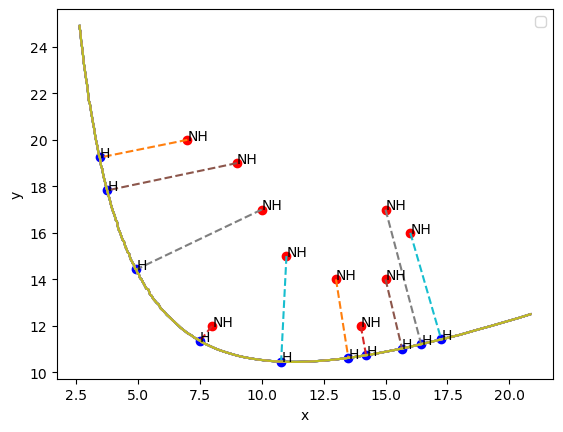

In [24]:
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])

optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]): 
    
    data_pt = undesired_df.iloc[r]  

    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), contours_val=False, N=100000, step_size=0.1, margin=0.0001, test=True)
    
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

# Optimal Points # 

These are the optimal data points for the non-healthy data points using the distance algorithm instead. 

In [25]:
optimal_datapts

,x1,x2
0,3.467452,19.241272
1,7.511897,11.355763
2,3.769211,17.826748
3,4.939847,14.426166
4,10.785017,10.459661
5,13.497390,10.621009
6,14.214296,10.735733
7,15.664486,11.025191
8,16.437448,11.210780
9,17.246992,11.419477


In [27]:
dist_df_dist_algo = pd.DataFrame(data=[], columns=["distance"])

for k in range(optimal_datapts.shape[0]): 
    dist_df_dist_algo.loc[len(dist_df_dist_algo)] = J(optimal_datapts.iloc[k,0], optimal_datapts.iloc[k,1], undesired_df.iloc[k,0], undesired_df.iloc[k,1])

dist_df_dist_algo

,distance
0,3.613110
1,0.808261
2,5.360753
3,5.677127
4,4.545426
5,3.415403
6,1.282300
7,3.048119
8,5.965008
9,4.747229


# Difference in the distances found using each algorithm 

Since the distances should be similar, we expect that these values should be as close to 0 as possible.

In [33]:
abs_dists = dist_df_ortho_algo - dist_df_dist_algo

abs_dists

,distance
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


# Applying the Algorithm to Different Types of Models # 

We would like to test our algorithm to different types of models. In this case, we test the MLP classifier with the optimal_point function that we have made earlier. We create a training and testing split in order to see the results on the test set after fitting to the training set. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6.655416136416545


array([[14.21787618, 11.85178822]])

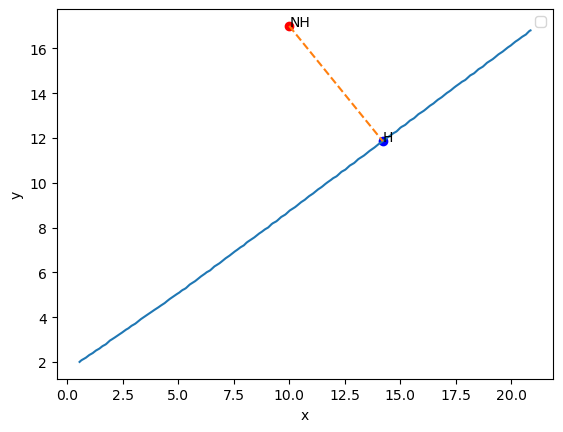

In [47]:
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1, max_iter=100000, hidden_layer_sizes=(100,25,25,1))
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']],df['y'], stratify=df['y'],
                                                    random_state=1)

optimal_point(df=pd.concat([X_train, y_train],axis=1), model=clf, desired_class=1, undesired_coords=(10,17), N=100000, step_size=0.1, margin=0.00001)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.811097804378389


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8138260801083304


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4404120975844315


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.6339854097505655
3.6715902899979285


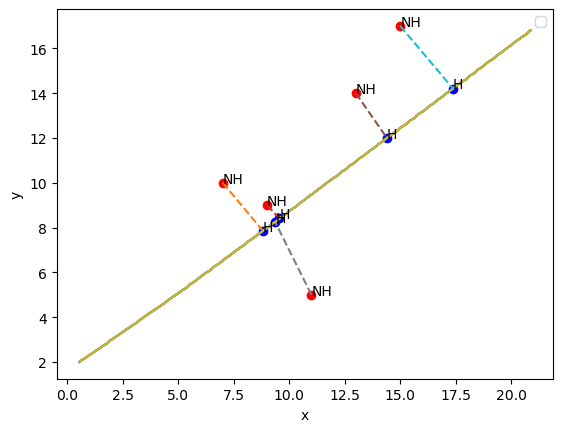

In [48]:
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))
test_set = pd.concat([X_test, y_test],axis=1)
for r in range(test_set.shape[0]):         
    # Undesired data point
    data_pt = test_set.iloc[r]  
    optimal_pt = optimal_point(df=pd.concat([X_train, y_train],axis=1), model=clf, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), N=100000, margin=0.00001, step_size=0.1)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

In [49]:
dist_df_ortho_algo = pd.DataFrame(data=[], columns=["distance"])

for k in range(optimal_datapts.shape[0]): 
    dist_df_ortho_algo.loc[len(dist_df_ortho_algo)] = J(optimal_datapts.iloc[k,0], optimal_datapts.iloc[k,1], test_set.iloc[k,0], test_set.iloc[k,1])

dist_df_ortho_algo

,distance
0,2.811098
1,0.813826
2,2.440412
3,3.633985
4,3.671590


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.79813675671726
0.8138260801083304


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4404120975844315
3.576180186876623


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.6600931455200825


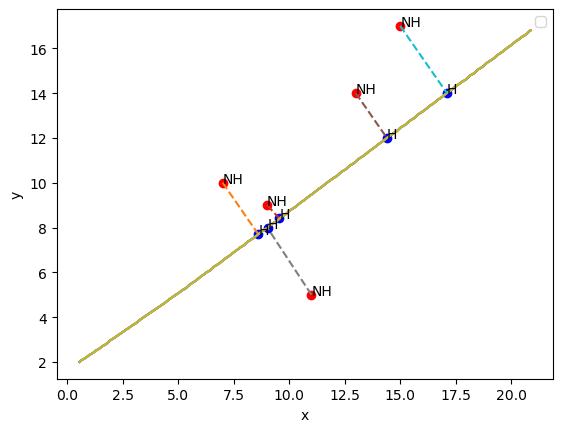

In [50]:
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))
test_set = pd.concat([X_test, y_test],axis=1)
for r in range(test_set.shape[0]):         
    # Undesired data point
    data_pt = test_set.iloc[r]  
    optimal_pt = optimal_point(df=pd.concat([X_train, y_train],axis=1), model=clf, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), N=100000, margin=0.00001, step_size=0.1, test=True)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

In [51]:
dist_df_dist_algo = pd.DataFrame(data=[], columns=["distance"])

for k in range(optimal_datapts.shape[0]): 
    dist_df_dist_algo.loc[len(dist_df_dist_algo)] = J(optimal_datapts.iloc[k,0], optimal_datapts.iloc[k,1], test_set.iloc[k,0], test_set.iloc[k,1])

dist_df_dist_algo

,distance
0,2.798137
1,0.813826
2,2.440412
3,3.576180
4,3.660093


# Differences in the distances computed from distance and orthogonality algorithms 

The absolute value of the distances computed from the distance algorithm is very similar to the distances computed from the orthogonality algorithm.

In [52]:
abs_dists = abs(dist_df_dist_algo - dist_df_ortho_algo)

abs_dists

,distance
0,0.012961
1,0.000000
2,0.000000
3,0.057805
4,0.011497


# Logistic Regression # 

We apply the optimal_point function to the logistic regression classifier and see the results after applying to the dataset.

In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=100000)

# Finding Optimal Points # 

The code below is the same as above. We use the orthogonality algorithm and not the distance algorithm to find the optimal points.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.244630082732938


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2406713091105048


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5.345738834405052


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.095113212407908


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.8349794190375186


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.957834609460762


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.7096729321179098


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.9488723025698174


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6.573748928249334
6.183891621805957


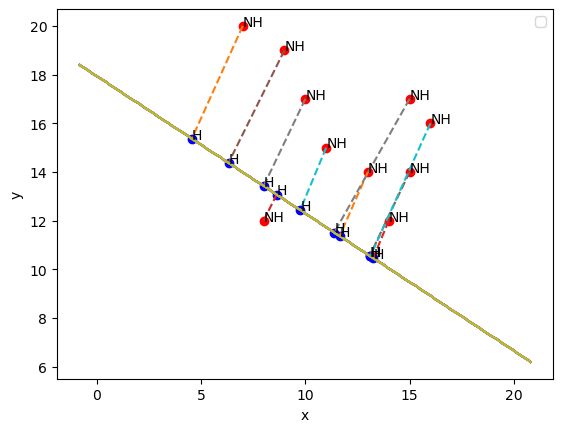

In [54]:
undesired_df = df.loc[df['y'] == -1]
undesired_df = undesired_df.drop(columns=['y'])
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]):         
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df=df, model=clf, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), N=100000, step_size=0.1, margin=0.0001, test=False)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]

In [56]:
dist_df_ortho_algo = pd.DataFrame(data=[], columns=["distance"])

for k in range(optimal_datapts.shape[0]): 
    dist_df_ortho_algo.loc[len(dist_df_ortho_algo)] = J(optimal_datapts.iloc[k,0], optimal_datapts.iloc[k,1], undesired_df.iloc[k,0], undesired_df.iloc[k,1])

dist_df_ortho_algo

,distance
0,5.244630
1,1.240671
2,5.345739
3,4.095113
4,2.834979
5,2.957835
6,1.709673
7,3.948872
8,6.573749
9,6.183892


# Finding Optimal Points # 

The code below is the same as above. We use the distance algorithm to find the optimal points.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprec

5.23635147370157


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

1.2386175111728093


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

5.347856360802648


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

4.095818295854123


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

2.848198453796719


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

2.959906074435108


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

1.7119894242855638


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

3.941951748771951


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

6.549901309177953


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = J(x,y, datapt[0], datapt[1])
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3614412754.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_point_vector = (datapt[0] - x, datapt[1] - y)
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_13008\3556254240.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

6.171934956547971


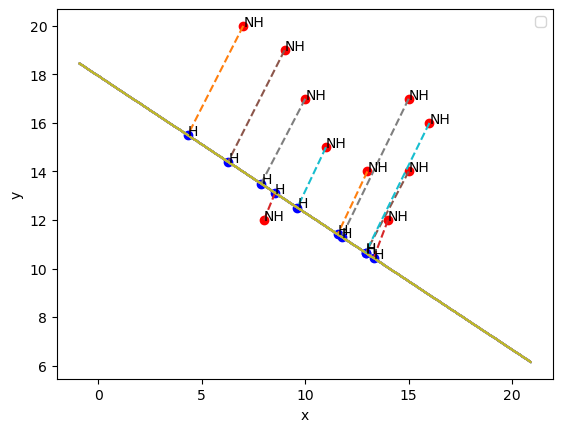

In [39]:
undesired_df = df.loc[df['y'] == -1]
undesired_df = undesired_df.drop(columns=['y'])
optimal_datapts = pd.DataFrame(data=[], columns=('x1', 'x2'))

for r in range(undesired_df.shape[0]):         
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df=df, model=clf, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), N=100000, step_size=0.1, margin=0.0001, test=True)
    optimal_datapts.loc[len(optimal_datapts)] = optimal_pt[0]